#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim GaussianCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [61]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*1.+0.0

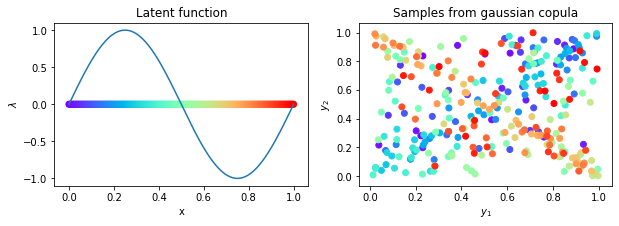

In [63]:
# here we generate some synthetic samples
from starvine.bvcopula.copula.gauss_copula import GaussCopula
import matplotlib.cm as cm

NSamp = 300

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,3))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

Y = np.zeros((NSamp,2))
copula = GaussCopula()
for i,x in enumerate(X):
    if scale(x) == 0:
        Y[i] = np.random.uniform(low=0,high=1,size=2)
    else:
        Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
colors = cm.rainbow(np.linspace(0, 1, NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from gaussian copula')

fig.show()

In [64]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda(device=0)
train_y = torch.tensor(Y).float()#.cuda(device=0)

In [451]:
help(constraints)

Help on module torch.distributions.constraints in torch.distributions:

NAME
    torch.distributions.constraints - The following constraints are implemented:

DESCRIPTION
    - ``constraints.boolean``
    - ``constraints.dependent``
    - ``constraints.greater_than(lower_bound)``
    - ``constraints.integer_interval(lower_bound, upper_bound)``
    - ``constraints.interval(lower_bound, upper_bound)``
    - ``constraints.lower_cholesky``
    - ``constraints.lower_triangular``
    - ``constraints.nonnegative_integer``
    - ``constraints.positive``
    - ``constraints.positive_definite``
    - ``constraints.positive_integer``
    - ``constraints.real``
    - ``constraints.real_vector``
    - ``constraints.simplex``
    - ``constraints.unit_interval``

CLASSES
    builtins.object
        Constraint
            _GreaterThan
            _GreaterThanEq
            _HalfOpenInterval
            _IntegerInterval
            _Interval
            _LessThan
    builtins.property(builtins.object)


In [891]:
from pyro.distributions.score_parts import ScoreParts
from pyro.distributions.torch_distribution import TorchDistribution
from torch.distributions import constraints
from torch.distributions.utils import _standard_normal

class GaussianCopulaDistribution(TorchDistribution):
    
    has_rsample = True
    arg_constraints = {"theta": constraints.interval(-1,1)}
    support = constraints.real
    
    def __init__(self, theta, validate_args=None):
        self.theta = theta
        batch_shape, event_shape = self.theta.shape[:-1], (self.theta.shape[-1:] + torch.Size([2]))
        print('Init copula with shapes: {}, {}'.format(batch_shape,event_shape))
        super(GaussianCopulaDistribution, self).__init__(batch_shape, event_shape, validate_args=validate_args)
        
    @staticmethod
    def _logit(x):
        return torch.log(x/(1-x))
    
    def expand(self, batch_shape, _instance=None):
        print('Time to expand')
        new = self._get_checked_instance(GaussianCopulaDistribution, _instance)
        batch_shape = torch.Size(batch_shape)
        print('Batch_shape: {}, event_shape: {}, desired batch shape: {}'.format(self.batch_shape,self.event_shape,batch_shape))
        theta_shape = batch_shape + torch.Size(self.event_shape[:-1])
        print(theta_shape)
        new.theta = self.theta.expand(theta_shape) # not sure if expand only batch dimension
        super(GaussianCopulaDistribution, new).__init__(batch_shape,
                                                self.event_shape,
                                                validate_args=False)
        new._validate_args = self._validate_args
        return new
    
    def ppcf(self, samples, theta):
        nrvs = self._logit(samples)
        vals = torch.sigmoid(nrvs[..., 0] * torch.sqrt(1 - self.theta**2) + 
                             nrvs[..., 1] * self.theta)
        return vals

    def rsample(self, sample_shape=torch.Size([])):
        shape = self._extended_shape(sample_shape) # now it is theta_size (batch) x sample_size x 2 (event)
        
        if sample_shape == torch.Size([]):   # not sure what to do with 1 sample
            shape = torch.Size([1]) + shape
            
        samples = torch.rand(shape)
        samples[:,:,0] = self.ppcf(samples, self.theta)
        return samples

    def log_prob(self, value):
        # unittest
        # m = GaussianCopulaDistribution(torch.tensor([0,-1,1,0.5,0.4,0.7]).float())
        # m.log_prob(m.sample())
        if self._validate_args:
            self._validate_sample(value)
        assert value.shape[-1] == 2 #check that the samples are pairs of variables
        log_prob = torch.zeros(value.shape[:-1]) # by default
        
        if self.theta.dim() > (value.dim()-1):
            thetas = self.theta[0]
        else:
            thetas = self.theta
        
        log_prob[(thetas >= 1.0)  & (value[..., 0] == value[..., 1])]     = float("Inf") 
        log_prob[(thetas <= -1.0) & (value[..., 0] == 1 - value[..., 1])] = float("Inf") 
        
        nrvs = self._logit(value) #TODO substitute for proper ppf of Normal distrib
        mask = (thetas < 1.0) & (thetas > -1.0)
        log_prob[..., mask] = (2 * thetas * nrvs[..., 0] * nrvs[..., 1] - thetas**2 \
            * (nrvs[..., 0]**2 + nrvs[..., 1]**2))[..., mask]
        log_prob[..., mask] /= 2 * (1 - thetas**2)[..., mask]
        log_prob[..., mask] -= torch.log(1 - thetas**2)[..., mask] / 2
        print(log_prob.shape)
        return log_prob


    def entropy(self):
        raise NotImplementedError
#         half_log_det = self._unbroadcasted_scale_tril.diagonal(dim1=-2, dim2=-1).log().sum(-1)
#         H = 0.5 * self._event_shape[0] * (1.0 + math.log(2 * math.pi)) + half_log_det
#         if len(self._batch_shape) == 0:
#             return H
#         else:
#             return H.expand(self._batch_shape)

In [892]:
ran = torch.rand(10)
ran.expand(torch.Size([2,10]))
ran.dim()

1

Init copula with shapes: torch.Size([]), torch.Size([300, 2])


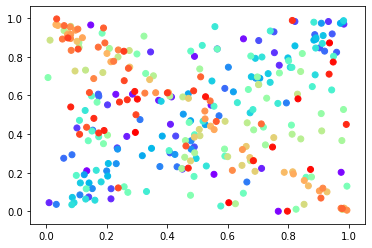

In [893]:
vec_scale = np.vectorize(scale)
scales = vec_scale(X)
m = GaussianCopulaDistribution(torch.tensor(scales).float())#torch.ones(100)*0.7)
plt.scatter(*m.sample().numpy().T,color=colors)

In [894]:
m = base_distributions.Exponential(torch.tensor([1,2,3,4,5]).float())
m.sample(torch.Size([3]))

tensor([[2.7427e+00, 5.3451e-01, 6.6728e-02, 1.8379e-01, 1.1334e-01],
        [8.1685e-03, 1.7309e-01, 7.6259e-02, 1.2330e-01, 1.9403e-01],
        [2.9204e+00, 4.3331e-01, 1.1939e+00, 3.0654e-01, 1.3307e-03]])

In [895]:
class PVGPRegressionModel(gpytorch.models.PyroVariationalGP):
    def __init__(self, train_x, train_y, likelihood, name_prefix="mixture_gp"):
        # Define all the variational stuff
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=train_x.numel()
        )
        variational_strategy = myVariationalStrategy(
            self, train_x, variational_distribution
        )
        
        # Standard initializtation
        super(PVGPRegressionModel, self).__init__(variational_strategy, likelihood, num_data=train_x.numel())
        self.likelihood = likelihood
        
        # Mean, covar
        self.mean_module = gpytorch.means.ConstantMean()
        
        #we specify prior here
        prior_rbf_length = 0.3 
        lengthscale_prior = gpytorch.priors.NormalPrior(prior_rbf_length, 1.0) #variance does not matter much
        
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
        )
        
        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        #self.covar_module.outputscale = outputscale_prior.mean

    def forward(self, x):
        mean = self.mean_module(x)  # Returns an n_data vec
        covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

In [909]:
from torch import Tensor
from typing import Any
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.distributions import MultivariateNormal, base_distributions
from gpytorch.utils.deprecation import _deprecate_kwarg_with_transform

class GaussCopula_Likelihood(Likelihood):
    def __init__(self, noise_prior=None, noise_constraint=None, batch_shape=torch.Size(), **kwargs: Any):
        batch_shape = _deprecate_kwarg_with_transform(
            kwargs, "batch_size", "batch_shape", batch_shape, lambda n: torch.Size([n])
        )
        super(Likelihood, self).__init__()
        self._max_plate_nesting = 2
    
    @staticmethod
    def gplink_function(f: Tensor) -> Tensor:
        """
        GP link function transforms the GP latent variable `f` into :math:`\theta`,
        which parameterizes the distribution in :attr:`forward` method as well as the
        log likelihood of this distribution defined in :attr:`expected_log_prob`.
        """
        return (2*torch.sigmoid(f) - 1)
    
    def forward(self, function_samples: Tensor, *params: Any, **kwargs: Any) -> GaussianCopulaDistribution:
        scale = self.gplink_function(function_samples)
        return GaussianCopulaDistribution(scale)
    
#     def pyro_sample_output(self, observations, function_dist, *params, **kwargs):
#         name_prefix = kwargs.get("name_prefix", "")

#         # Get the correct sample shape
#         # The default sample shape includes all the batch dimensions that can be sampled from
#         sample_shape = kwargs.pop("sample_shape", torch.Size([1] * len(function_dist.batch_shape)))
#         sample_shape = sample_shape[:-len(function_dist.batch_shape)]
#         function_samples = function_dist(sample_shape)
#         output_dist = self(function_samples, *params, **kwargs)
# #         print("Likelihood sample: {}, function: {}, output {}, obs: {}".
# #               format(sample_shape,function_samples.shape,output_dist,observations.shape))
#         with pyro.plate(name_prefix + ".output_values_plate", function_dist.batch_shape[-1], dim=-1):
#             samples = pyro.sample(name_prefix + ".output_values", output_dist, obs=observations)
#             return samples
    

In [910]:
# define the model (optionally on GPU)
model = PVGPRegressionModel(train_x, train_y, GaussCopula_Likelihood())#.cuda(device=0)

In [911]:
# train the model
from pyro import optim

base_lr = 1./NSamp
iter_print = 50

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .1}
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

means.append(model.variational_strategy.variational_distribution.\
             variational_mean.detach().cpu().numpy()) #save initial mean

def train(num_iter=200):
    elbo = pyro.infer.Trace_ELBO(num_particles=256, vectorize_particles=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        if not (i + 1) % iter_print:
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(),
            ))
            means.append(model.variational_strategy.variational_distribution.\
                         variational_mean.detach().cpu().numpy())
        
%time train()

Basic lr for most of parameters: 0.0033333333333333335
Init copula with shapes: torch.Size([]), torch.Size([300, 2])
Time to expand
Batch_shape: torch.Size([]), event_shape: torch.Size([300, 2]), desired batch shape: torch.Size([300])
torch.Size([300, 300])
torch.Size([300])
Init copula with shapes: torch.Size([256]), torch.Size([300, 2])


ValueError: Shape mismatch inside plate('.output_values_plate') at site .output_values dim -1, 300 vs 256
                                                                   Trace Shapes:                
                                                                    Param Sites:                
      .gp_prior$$$variational_strategy.variational_distribution.variational_mean         300    
.gp_prior$$$variational_strategy.variational_distribution.chol_variational_covar     300 300    
                                                .gp_prior$$$mean_module.constant           1    
                                        .gp_prior$$$covar_module.raw_outputscale                
                            .gp_prior$$$covar_module.base_kernel.raw_lengthscale       1   1    
                                                                   Sample Sites:                
                                                   num_particles_vectorized dist           |    
                                                                           value     256   |    
                                                           .inducing_values dist 256   1   | 300
                                                                           value 256   1   | 300
                                                       .output_values_plate dist           |    
                                                                           value     300   |    

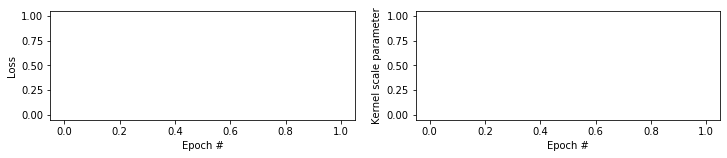

In [908]:
# prot loss function and kernel length
fig, (loss, kern) = plt.subplots(1,2,figsize=(12,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
fig.show()

In [874]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float()#.cuda()

Shapes: torch.Size([10]), torch.Size([300, 2])


/home/nina/.envs/GPyTorch/lib/python3.6/site-packages/gpytorch/lazy/cached_cg_lazy_tensor.py:161: UserWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([300, 1200]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  "LazyTensor should pre-register all vectors to run CG against.".format(rhs.shape)


RuntimeError: The expanded size of the tensor (2) must match the existing size (300) at non-singleton dimension 2.  Target sizes: [1, 10, 2].  Tensor sizes: [10, 300]

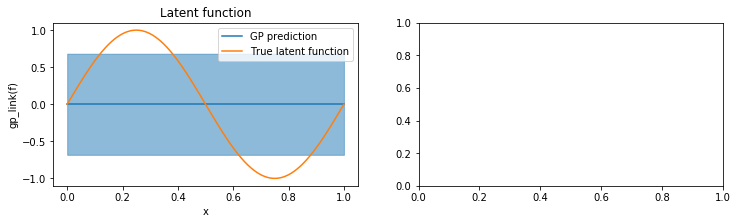

In [807]:
# visualize the result
fig, (func, samp) = plt.subplots(1,2,figsize=(12, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
    
F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
Y_sim = model.likelihood(model(train_x)).rsample().detach().numpy()[0] # first dim are samples of f, we plot 1 of them
samp.scatter(X,Y, alpha = 0.5, label = 'True train data')
samp.scatter(X,Y_sim, alpha = 0.5, label = 'Sample from the model')
samp.set_xlabel('x')
samp.set_ylabel('y')
samp.set_title('Samples from exp. distrib. with scale=gplink(f(x))')
samp.legend()

fig.show()

In [13]:
np.shape(model.likelihood(model(train_x)).rsample(torch.Size([200])).detach().numpy())

(200, 10, 100)

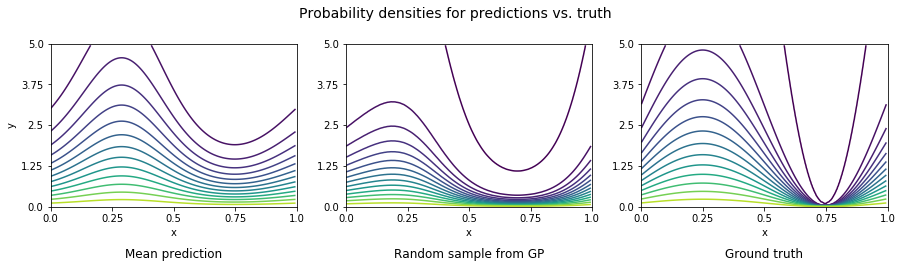

In [14]:
# visualize pdf for y(x)

from scipy import stats

Nbins = 100

latent_sample = gplink(output.sample()).cpu().numpy()

img = np.zeros((Nbins,denser*NSamp,3))
h = np.linspace(1e-4,5,Nbins)

for i, (l, m, t) in enumerate(zip(latent_sample, F_mean, scale(testX)+1e-2)):
    img[:,i,0] = stats.expon.pdf(h, scale=m)
    img[:,i,1] = stats.expon.pdf(h, scale=l)
    img[:,i,2] = stats.expon.pdf(h, scale=t)

img = img / np.max(img,axis=0) # normalize pdf, so that max(pdf) = 1

num_levels = 15

levels = np.exp(np.linspace(1e-4,1,num_levels))
levels -= 1
levels /= np.max(levels)

fig, ax = plt.subplots(1,3, figsize = (15,3))
for c, n in enumerate(['Mean prediction', 'Random sample from GP', 'Ground truth']):
    ax[c].contour(img[:,:,c], levels = levels)
    ax[c].set_yticks(np.linspace(0,Nbins,5))
    ax[c].set_yticklabels(np.linspace(0,5,5))
    ax[c].set_xticks(np.linspace(0,denser*NSamp,5))
    ax[c].set_xticklabels(np.linspace(0,1,5))
    ax[c].set_xlabel('x')
    ax[c].set_title(n, y=-0.35)
ax[0].set_ylabel('y')
fig.suptitle('Probability densities for predictions vs. truth', y=1.05, fontsize=14);